# 03 - Weight-Tied LSTMs
By Jan Christian Blaise B. Cruz

This notebook is the conclusion of what we know as "standard neural language model practices." We started with a normal LSTM-based model, then applied recurrent regularization. In this notebook, we'll explore another de facto common practice, called weight tying.

Let's start with the imports.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchtext.data import Field, BPTTIterator
from torchtext.datasets import PennTreebank, WikiText2
import spacy

import numpy as np
import pandas as pd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

We'll use the Torchtext library to load and prepare our dataset. Again, we'll use the WikiText-2 dataset splitting them into train, valid, and test sets, tokenizing them with SpaCy's english tokenizer, and building the vocabulary with words of frequency of at least 2.

In [0]:
# Tokenizer
spacy_en = spacy.load('en')
def tokenize(s):
    return [tok.text for tok in spacy_en.tokenizer(s)]

# Prepare a field and get the data
TEXT = Field(lower=True, tokenize=tokenize)
train_data, valid_data, test_data = WikiText2.splits(TEXT)

# Build the vocabulary
TEXT.build_vocab(train_data, min_freq=2)
print("Vocab size: {}".format(len(TEXT.vocab)))

Vocab size: 28870


We'll batch them, again using the ```BPTTIterator``` following common conventions on batch size and sequence length.

In [0]:
batch_size = 80
bptt_len = 80

train_loader, valid_loader, test_loader = BPTTIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=batch_size, bptt_len=bptt_len, 
    device=device, 
    repeat=False
)

For convenience, we'll define recurrent dropout like we did in the previous notebook.

In [0]:
# Credits to the contributors at fast.ai
def dropout_mask(x, sz, p):
    return x.new(*sz).bernoulli_(1-p).div_(1-p)
  
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: 
          return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

# Weight-Tied LSTM Language Model
A key difference in this iteration is that we'll be using what is called "weight tying," where two layers would share the exact same weights. There are two advantages to this approach: first is that tying weights will obviously reduce the total number of parameters to optimize, thus slimming down the model and reducing complexity. Second, this approach has been shown to reduce perplexity with empirical results (Press & Wolf, 2016) and with theoretical motivations (Inan et al., 2016).

We'll modify our previous model to account for weight tying, as shown below.

In [0]:
class WTLSTMLanguageModel(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, num_layers=1, hidden_dp=0.5, tie_weights=True):
        super(WTLSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        
        # Modify the output dimension of the last layer to output embedding_dim
        self.rnns = [nn.LSTM(embedding_dim if l == 0 else hidden_dim, 
                             (hidden_dim if l != num_layers - 1 else embedding_dim) if tie_weights else hidden_dim) for l in range(num_layers)]
        self.rnns = nn.ModuleList(self.rnns)
        
        # Modify the fully-connected layer to take in embedding_dim sized tensors
        self.fc1 = nn.Linear(embedding_dim if tie_weights else hidden_dim, vocab_sz)
        self.hidden_dropout = RNNDropout(hidden_dp)
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        
        # Tie the weights.
        if tie_weights:
            self.fc1.weight = self.embedding.weight
        
    def init_hidden(self, bs):
        # No need to modify this as self.rnns[i].hidden_size will take care of
        # getting the right sizes for us
        weight = next(self.parameters()).data
        return [(weight.new(1, bs, self.rnns[i].hidden_size).zero_(), 
                 weight.new(1, bs, self.rnns[i].hidden_size).zero_()) for i in range(len(self.rnns))]
    
    def forward(self, x):
        bptt_len, bs = x.shape
        vocab_sz = self.embedding.num_embeddings
        
        out = self.embedding(x)
        hiddens = self.init_hidden(bs)
        for i, rnn in enumerate(self.rnns):   
            out, (hidden, cell) = rnn(out, hiddens[i])
            out = self.hidden_dropout(out)
        
        out = out.flatten(0, 1)
        out = self.fc1(out)
        out = out.view(bptt_len, bs, vocab_sz)
        return out

We'll use the "medium sized model" as noted in Press & Wolf (2016), which borrows the setup from Zaremba et al., (2014). We use a two-layer LSTM language model with 300-dimension embeddings and 650 units in the hidden layers. We use a recurrent dropout of 0.65 on the hidden-to-hidden connections of the LSTMs. We optimize using Adam (Kingma & Ba, 2014) using a cross-entropy objective. We use a base learning rate of $1e-2$ without annealing. All parameters are initialized to a uniform distribution between $[-0.01, 0.01]$.

Note the overall reduction in parameters compared to our last model.

In [0]:
model = WTLSTMLanguageModel(vocab_sz=len(TEXT.vocab), embedding_dim=300, hidden_dim=650, 
                            num_layers=2, hidden_dp=0.65, tie_weights=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.01, 0.01)
            
model.apply(init_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,307,470 trainable parameters


We'll train the model for 100 epochs and use gradient clipping to prevent exploding gradients. We save the best model trained every iteration as needed.

Do note that running this cell will last a little under 4 hours in a fairly recent GPU. Instead of training, you may download my pretrained weights (trained using the same cell below) in the same dirrectory as this notebook in the repo.

In [7]:
epochs = 100
clip = 0.25
train_losses = []
valid_losses = []
best = np.inf

for e in range(1, epochs + 1):
    model.train()    
    train_loss = 0 
    for batch in tqdm(train_loader):
        x, y = batch.text, batch.target
        out = model(x)
        
        loss = criterion(out.flatten(0, 1), y.flatten())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_ppl = np.exp(train_loss)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            x, y = batch.text, batch.target
            out = model(x)
            loss = criterion(out.flatten(0, 1), y.flatten())

            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_ppl = np.exp(valid_loss)
    valid_losses.append(valid_loss)
    
    if valid_loss < best:
        print("Best model so far. Saving model...")
        best = valid_loss
        torch.save({'state_dict': model.state_dict()}, 'wtlstm-wt2.pth')
    
    print("\nEpoch {:3d} | Train Loss {:.4f} | Valid Loss {:.4f} | Train Ppl {:.4f} | Valid Ppl {:.4f}".format(e, train_loss, valid_loss, train_ppl, valid_ppl))

  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   1 | Train Loss 6.9242 | Valid Loss 5.3601 | Train Ppl 1016.6230 | Valid Ppl 212.7545


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   2 | Train Loss 5.7289 | Valid Loss 5.0032 | Train Ppl 307.6365 | Valid Ppl 148.8890


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   3 | Train Loss 5.4669 | Valid Loss 4.8460 | Train Ppl 236.7227 | Valid Ppl 127.2266


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   4 | Train Loss 5.3093 | Valid Loss 4.7436 | Train Ppl 202.2126 | Valid Ppl 114.8459


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   5 | Train Loss 5.1996 | Valid Loss 4.6775 | Train Ppl 181.2022 | Valid Ppl 107.4975


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   6 | Train Loss 5.1233 | Valid Loss 4.6303 | Train Ppl 167.8802 | Valid Ppl 102.5413


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   7 | Train Loss 5.0630 | Valid Loss 4.5926 | Train Ppl 158.0677 | Valid Ppl 98.7468


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   8 | Train Loss 5.0146 | Valid Loss 4.5620 | Train Ppl 150.5938 | Valid Ppl 95.7727


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch   9 | Train Loss 4.9761 | Valid Loss 4.5394 | Train Ppl 144.9078 | Valid Ppl 93.6362


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  10 | Train Loss 4.9428 | Valid Loss 4.5210 | Train Ppl 140.1689 | Valid Ppl 91.9235


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  11 | Train Loss 4.9162 | Valid Loss 4.5047 | Train Ppl 136.4849 | Valid Ppl 90.4370


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  12 | Train Loss 4.8922 | Valid Loss 4.4951 | Train Ppl 133.2516 | Valid Ppl 89.5791


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  13 | Train Loss 4.8721 | Valid Loss 4.4846 | Train Ppl 130.5910 | Valid Ppl 88.6389


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  14 | Train Loss 4.8525 | Valid Loss 4.4732 | Train Ppl 128.0559 | Valid Ppl 87.6375


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  15 | Train Loss 4.8368 | Valid Loss 4.4673 | Train Ppl 126.0635 | Valid Ppl 87.1221


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  16 | Train Loss 4.8225 | Valid Loss 4.4649 | Train Ppl 124.2801 | Valid Ppl 86.9112


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  17 | Train Loss 4.8091 | Valid Loss 4.4542 | Train Ppl 122.6211 | Valid Ppl 85.9834


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  18 | Train Loss 4.7975 | Valid Loss 4.4526 | Train Ppl 121.2126 | Valid Ppl 85.8511


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  19 | Train Loss 4.7866 | Valid Loss 4.4501 | Train Ppl 119.8871 | Valid Ppl 85.6326


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  20 | Train Loss 4.7761 | Valid Loss 4.4439 | Train Ppl 118.6431 | Valid Ppl 85.1024


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  21 | Train Loss 4.7668 | Valid Loss 4.4395 | Train Ppl 117.5448 | Valid Ppl 84.7298


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  22 | Train Loss 4.7573 | Valid Loss 4.4405 | Train Ppl 116.4301 | Valid Ppl 84.8194


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  23 | Train Loss 4.7502 | Valid Loss 4.4353 | Train Ppl 115.6085 | Valid Ppl 84.3785


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  24 | Train Loss 4.7434 | Valid Loss 4.4300 | Train Ppl 114.8254 | Valid Ppl 83.9350


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  25 | Train Loss 4.7362 | Valid Loss 4.4306 | Train Ppl 114.0001 | Valid Ppl 83.9801


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  26 | Train Loss 4.7335 | Valid Loss 4.4297 | Train Ppl 113.6968 | Valid Ppl 83.9036


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  27 | Train Loss 4.7242 | Valid Loss 4.4286 | Train Ppl 112.6417 | Valid Ppl 83.8105


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  28 | Train Loss 4.7202 | Valid Loss 4.4217 | Train Ppl 112.1859 | Valid Ppl 83.2360


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  29 | Train Loss 4.7121 | Valid Loss 4.4272 | Train Ppl 111.2802 | Valid Ppl 83.6955


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  30 | Train Loss 4.7096 | Valid Loss 4.4295 | Train Ppl 111.0055 | Valid Ppl 83.8871


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  31 | Train Loss 4.7059 | Valid Loss 4.4264 | Train Ppl 110.5933 | Valid Ppl 83.6259


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  32 | Train Loss 4.7009 | Valid Loss 4.4214 | Train Ppl 110.0421 | Valid Ppl 83.2137


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  33 | Train Loss 4.6978 | Valid Loss 4.4232 | Train Ppl 109.7004 | Valid Ppl 83.3589


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  34 | Train Loss 4.6935 | Valid Loss 4.4192 | Train Ppl 109.2314 | Valid Ppl 83.0294


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  35 | Train Loss 4.6902 | Valid Loss 4.4190 | Train Ppl 108.8767 | Valid Ppl 83.0170


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  36 | Train Loss 4.6855 | Valid Loss 4.4217 | Train Ppl 108.3678 | Valid Ppl 83.2363


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  37 | Train Loss 4.6822 | Valid Loss 4.4185 | Train Ppl 108.0100 | Valid Ppl 82.9739


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  38 | Train Loss 4.6807 | Valid Loss 4.4187 | Train Ppl 107.8462 | Valid Ppl 82.9897


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  39 | Train Loss 4.6771 | Valid Loss 4.4233 | Train Ppl 107.4585 | Valid Ppl 83.3682


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  40 | Train Loss 4.6748 | Valid Loss 4.4195 | Train Ppl 107.2105 | Valid Ppl 83.0535


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  41 | Train Loss 4.6718 | Valid Loss 4.4142 | Train Ppl 106.8938 | Valid Ppl 82.6155


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  42 | Train Loss 4.6708 | Valid Loss 4.4140 | Train Ppl 106.7864 | Valid Ppl 82.6032


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  43 | Train Loss 4.6683 | Valid Loss 4.4176 | Train Ppl 106.5214 | Valid Ppl 82.8969


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  44 | Train Loss 4.6642 | Valid Loss 4.4118 | Train Ppl 106.0771 | Valid Ppl 82.4205


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  45 | Train Loss 4.6641 | Valid Loss 4.4177 | Train Ppl 106.0705 | Valid Ppl 82.9079


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  46 | Train Loss 4.6604 | Valid Loss 4.4147 | Train Ppl 105.6831 | Valid Ppl 82.6594


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  47 | Train Loss 4.6584 | Valid Loss 4.4145 | Train Ppl 105.4701 | Valid Ppl 82.6397


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  48 | Train Loss 4.6568 | Valid Loss 4.4074 | Train Ppl 105.3034 | Valid Ppl 82.0570


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  49 | Train Loss 4.6578 | Valid Loss 4.4132 | Train Ppl 105.4058 | Valid Ppl 82.5311


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  50 | Train Loss 4.6546 | Valid Loss 4.4098 | Train Ppl 105.0670 | Valid Ppl 82.2545


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  51 | Train Loss 4.6509 | Valid Loss 4.4121 | Train Ppl 104.6785 | Valid Ppl 82.4406


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  52 | Train Loss 4.6498 | Valid Loss 4.4074 | Train Ppl 104.5657 | Valid Ppl 82.0531


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  53 | Train Loss 4.6480 | Valid Loss 4.4063 | Train Ppl 104.3763 | Valid Ppl 81.9687


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  54 | Train Loss 4.6465 | Valid Loss 4.4107 | Train Ppl 104.2233 | Valid Ppl 82.3268


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  55 | Train Loss 4.6449 | Valid Loss 4.4100 | Train Ppl 104.0516 | Valid Ppl 82.2724


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  56 | Train Loss 4.6428 | Valid Loss 4.4056 | Train Ppl 103.8319 | Valid Ppl 81.9075


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  57 | Train Loss 4.6416 | Valid Loss 4.4127 | Train Ppl 103.7076 | Valid Ppl 82.4923


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  58 | Train Loss 4.6399 | Valid Loss 4.4092 | Train Ppl 103.5380 | Valid Ppl 82.2018


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  59 | Train Loss 4.6376 | Valid Loss 4.4134 | Train Ppl 103.2937 | Valid Ppl 82.5488


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  60 | Train Loss 4.6367 | Valid Loss 4.4085 | Train Ppl 103.2073 | Valid Ppl 82.1425


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  61 | Train Loss 4.6379 | Valid Loss 4.4093 | Train Ppl 103.3265 | Valid Ppl 82.2135


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  62 | Train Loss 4.6349 | Valid Loss 4.4131 | Train Ppl 103.0206 | Valid Ppl 82.5229


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  63 | Train Loss 4.6342 | Valid Loss 4.4124 | Train Ppl 102.9469 | Valid Ppl 82.4659


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  64 | Train Loss 4.6327 | Valid Loss 4.4115 | Train Ppl 102.7924 | Valid Ppl 82.3951


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  65 | Train Loss 4.6315 | Valid Loss 4.4083 | Train Ppl 102.6693 | Valid Ppl 82.1330


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  66 | Train Loss 4.6300 | Valid Loss 4.4047 | Train Ppl 102.5141 | Valid Ppl 81.8338


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  67 | Train Loss 4.6288 | Valid Loss 4.4040 | Train Ppl 102.3890 | Valid Ppl 81.7779


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  68 | Train Loss 4.6277 | Valid Loss 4.4107 | Train Ppl 102.2786 | Valid Ppl 82.3291


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  69 | Train Loss 4.6288 | Valid Loss 4.4098 | Train Ppl 102.3900 | Valid Ppl 82.2563


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  70 | Train Loss 4.6290 | Valid Loss 4.4116 | Train Ppl 102.4115 | Valid Ppl 82.4053


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  71 | Train Loss 4.6254 | Valid Loss 4.4138 | Train Ppl 102.0479 | Valid Ppl 82.5796


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  72 | Train Loss 4.6240 | Valid Loss 4.4124 | Train Ppl 101.9033 | Valid Ppl 82.4671


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  73 | Train Loss 4.6216 | Valid Loss 4.4047 | Train Ppl 101.6553 | Valid Ppl 81.8334


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  74 | Train Loss 4.6227 | Valid Loss 4.4101 | Train Ppl 101.7694 | Valid Ppl 82.2805


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  75 | Train Loss 4.6203 | Valid Loss 4.4106 | Train Ppl 101.5277 | Valid Ppl 82.3220


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  76 | Train Loss 4.6200 | Valid Loss 4.4076 | Train Ppl 101.4974 | Valid Ppl 82.0717


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  77 | Train Loss 4.6214 | Valid Loss 4.4091 | Train Ppl 101.6369 | Valid Ppl 82.1956


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  78 | Train Loss 4.6189 | Valid Loss 4.4056 | Train Ppl 101.3792 | Valid Ppl 81.9117


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  79 | Train Loss 4.6209 | Valid Loss 4.4107 | Train Ppl 101.5903 | Valid Ppl 82.3297


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  80 | Train Loss 4.6161 | Valid Loss 4.4080 | Train Ppl 101.0947 | Valid Ppl 82.1027


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  81 | Train Loss 4.6156 | Valid Loss 4.4097 | Train Ppl 101.0465 | Valid Ppl 82.2437


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  82 | Train Loss 4.6172 | Valid Loss 4.4081 | Train Ppl 101.2149 | Valid Ppl 82.1159


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  83 | Train Loss 4.6160 | Valid Loss 4.4095 | Train Ppl 101.0878 | Valid Ppl 82.2258


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  84 | Train Loss 4.6132 | Valid Loss 4.4067 | Train Ppl 100.8016 | Valid Ppl 82.0001


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  85 | Train Loss 4.6117 | Valid Loss 4.4081 | Train Ppl 100.6517 | Valid Ppl 82.1173


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  86 | Train Loss 4.6114 | Valid Loss 4.4037 | Train Ppl 100.6259 | Valid Ppl 81.7507


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  87 | Train Loss 4.6097 | Valid Loss 4.4054 | Train Ppl 100.4586 | Valid Ppl 81.8939


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  88 | Train Loss 4.6098 | Valid Loss 4.4078 | Train Ppl 100.4661 | Valid Ppl 82.0914


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  89 | Train Loss 4.6134 | Valid Loss 4.4061 | Train Ppl 100.8294 | Valid Ppl 81.9481


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  90 | Train Loss 4.6132 | Valid Loss 4.4065 | Train Ppl 100.8049 | Valid Ppl 81.9841


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  91 | Train Loss 4.6100 | Valid Loss 4.4047 | Train Ppl 100.4813 | Valid Ppl 81.8346


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  92 | Train Loss 4.6089 | Valid Loss 4.4039 | Train Ppl 100.3711 | Valid Ppl 81.7657


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  93 | Train Loss 4.6088 | Valid Loss 4.4032 | Train Ppl 100.3596 | Valid Ppl 81.7112


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  94 | Train Loss 4.6092 | Valid Loss 4.4057 | Train Ppl 100.4065 | Valid Ppl 81.9140


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  95 | Train Loss 4.6077 | Valid Loss 4.4055 | Train Ppl 100.2527 | Valid Ppl 81.9005


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  96 | Train Loss 4.6079 | Valid Loss 4.4060 | Train Ppl 100.2738 | Valid Ppl 81.9431


  0%|          | 0/350 [00:00<?, ?it/s]

Best model so far. Saving model...

Epoch  97 | Train Loss 4.6071 | Valid Loss 4.3999 | Train Ppl 100.1929 | Valid Ppl 81.4439


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  98 | Train Loss 4.6075 | Valid Loss 4.4035 | Train Ppl 100.2359 | Valid Ppl 81.7347


  0%|          | 0/350 [00:00<?, ?it/s]


Epoch  99 | Train Loss 4.6072 | Valid Loss 4.4016 | Train Ppl 100.1996 | Valid Ppl 81.5799


100%|██████████| 39/39 [00:04<00:00,  7.87it/s]


Epoch 100 | Train Loss 4.6059 | Valid Loss 4.4064 | Train Ppl 100.0774 | Valid Ppl 81.9769


We can see from the curves that the losses converged smoothly. In truth, there is a high chance that the model hasn't *fully* converged yet, but miniscule changes in the training and validation losses from epochs 80 to 100 give us a good indication that we can stop training early as it has reached an acceptable solution.

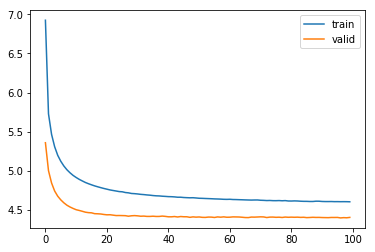

In [8]:
pd.DataFrame(data={'train':train_losses, 'valid':valid_losses}).plot.line()

Let's load the best model and check test perplexity.

This yields us again better perplexity than our previous model.

In [9]:
checkpoint = torch.load('wtlstm-wt2.pth')
model.load_state_dict(checkpoint['state_dict'])

model.eval()
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch.text, batch.target
        out = model(x)
        loss = criterion(out.flatten(0, 1), y.flatten())

        test_loss += loss.item()
test_loss /= len(test_loader)
test_ppl = np.exp(test_loss)

print("\nTest Loss {:.4f} | Test Ppl {:.4f}".format(test_loss, test_ppl))

100%|██████████| 44/44 [00:05<00:00,  8.08it/s]


Test Loss 4.2817 | Test Ppl 72.3656


We'll implement beam search to generate text.

In [0]:
# This implementation deffo could use some work. I just wrote this
# from the top of my head after a couple drinks HAHA. If you see any
# errors, don't be afraid to reach out!
def get_candidates(text, score, k=5):
    s = torch.LongTensor([TEXT.vocab.stoi[w] for w in tokenize(text)]).unsqueeze(0)
    out = model(s)
    probs = torch.softmax(out.squeeze(0)[-1], dim=0)
    scores, indices = torch.topk(probs, k)
    words = [TEXT.vocab.itos[i] for i in indices]
    checks = set(['<', '>', 'unk', '<eos>', '<sos>', '.', '"', '=', '(', ')', ','])
    candidates = [text + " " + c for c in words if c not in checks]
    scores = scores * score
    return scores, candidates

def beam_search(text, n_words, k):
    scores, cands = get_candidates(text, 1)
    for i in tqdm(range(n_words)):
        ncands = []
        nscores = []
        for s, c in zip(scores, cands):
          ns, nc = get_candidates(c, s, k=k)
          ncands.extend(nc)
          nscores.extend(ns)
        scores = []
        cands = []
        for c, s in sorted(list(zip(ncands, nscores)), key=lambda x: x[1], reverse=True)[:k]:
          scores.append(s)
          cands.append(c)
    return cands[0]

And try it out.

In [23]:
n_words = 30
k = 10
text = "Fell out of bed butterfly bandaged but dont worry"
model.cpu();

out = beam_search(text, n_words, k)
print('\n' + out)

100%|██████████| 30/30 [00:22<00:00,  1.05s/it]


Fell out of bed butterfly bandaged but dont worry to make it is an end in the first to make it has become an attempt from an end the united of the first of a @-@ based with the first


In the next notebook, we'll move away from LSTM-based models for now and try out something new. We'll also look a little more in depth at the recurrence being done by the RNN unit we use.